# Analysis of standups on Slack

In [28]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re
from itertools import groupby
from operator import itemgetter
from datetime import datetime
import calendar

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

In [3]:
f = open("standup-formatted.json")
messages = pd.read_json(f)
f.close()

## Get usernames from join messages
Slack uses user IDs instead of usernames for most things except join messages which contain both. Here we read all join messages, group by ID taking the first username (there should only be one) and create a dictionary which can be used for `O(1)` username lookups.

In [4]:
channel_join_re = re.compile("^<@(U[A-Z0-9]+)\|(.+)>")
def get_user_map():
    get_id_name = lambda text: channel_join_re.match(text).groups()
    
    joins = messages[messages.subtype == "channel_join"]["text"].map(get_id_name)
    sorted(joins, key=itemgetter(0))
    gjoins = groupby(joins, key=itemgetter(0))
    return {uid: list(gs)[0][1] for uid, gs in gjoins}

user_map = get_user_map()

def get_username(msg):
    if msg["subtype"] == "bot_message":
        return msg["username"] #"tatsu"
    elif msg["user"] in user_map:
        return user_map[msg["user"]]
    else:
        return "Unknown"
    
messages["username"] = messages[messages["type"] == "message"].apply(get_username, axis=1)

## Add various date and time fields

- Python datetime type
- Week day name, e.g. Monday
- Time in 23:45 format
- Hour * 60 + minute
- Date only in 2016-11-09 format

In [5]:
messages["date"] = messages["ts"].map(lambda x: datetime.fromtimestamp(x))
messages["weekday"] = messages["date"].map(lambda date: calendar.day_name[date.weekday()])

messages["time"] = messages["date"].map(lambda date: date.strftime("%H:%M"))
messages["time_m"] = messages["date"].map(lambda date: date.hour*60+date.minute)
messages["date_only"] = messages["date"].map(lambda date: date.strftime("%Y-%m-%d"))

## Create a box plot of standup finish times

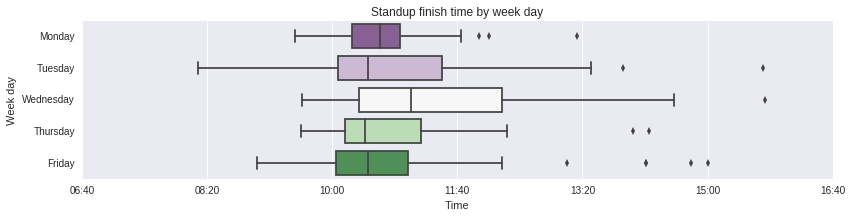

In [6]:
mask = (messages["username"]=="tatsu") & (messages["text"].apply(lambda t: "Thank you for your time today" in t))

standup_data = messages[mask]

def plot_finish_time(data):
    g = sb.factorplot(x="time_m", y="weekday",
                        data=data, width=0.75,
                        order=[calendar.day_name[i] for i in range(5)],
                        row_order=data["time_m"],
                        orient="h", size=3, aspect=4, palette="PRGn",
                        kind="box")
    
    g.set_xticklabels(["{:02d}:{:02d}".format(int(tm/60), int(tm%60)) for tm in plt.xticks()[0]]);
    g.set_axis_labels("Time","Week day");
    plt.title("Standup finish time by week day");
    sb.set(font_scale=1.5)

plot_finish_time(standup_data[standup_data.time_m-standup_data.time_m.mean() < 3*standup_data.time_m.std()])

## Create a regression plot of start time vs duration

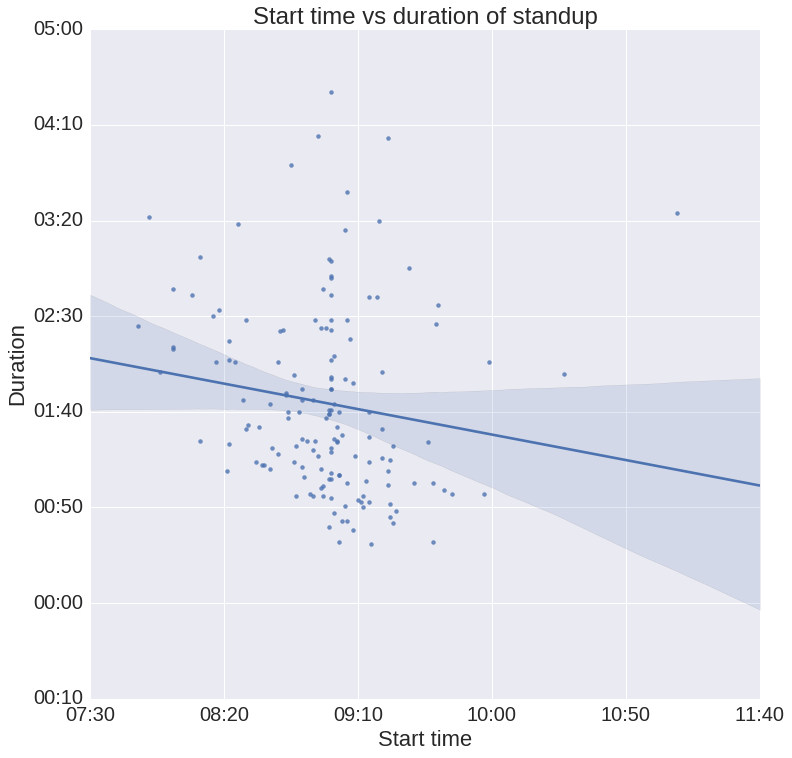

In [7]:
def get_start_times():
    mask = (messages["username"]=="tatsu") & (messages["text"].apply(lambda t: "Good morning" in t))
    standup_data = messages[mask]

    d = [(date, list(msgs["time_m"])[-1]) for date, msgs in standup_data.groupby(standup_data["date_only"])]
    return pd.DataFrame(d, columns=("date", "start_time_m"))
    
def get_end_times():
    mask = (messages["username"]=="tatsu") & (messages["text"].apply(lambda t: "Thank you for your time today" in t))
    standup_data = messages[mask]

    d = [(date, list(msgs["time_m"])[-1]) for date, msgs in standup_data.groupby(standup_data["date_only"])]
    return pd.DataFrame(d, columns=("date", "end_time_m"))

standup_days = pd.merge(get_start_times(), get_end_times(), on="date")
standup_days["duration"] = standup_days.apply(lambda day: day["end_time_m"]-day["start_time_m"], axis=1)
standup_days = standup_days[standup_days["duration"]-standup_days["duration"].mean() < 2*standup_days["duration"].std()]
standup_days = standup_days[standup_days["end_time_m"] - standup_days["start_time_m"] > 30]

plt.figure(figsize=(12,12))
sb.set(font_scale=2)
g = sb.regplot(x="start_time_m", y="duration", data=standup_days)
g.set_xticklabels(["{:02d}:{:02d}".format(int(tm/60), int(tm%60)) for tm in plt.xticks()[0]]);
g.set_yticklabels(["{:02d}:{:02d}".format(int(tm/60), int(tm%60)) for tm in plt.yticks()[0]]);
g.set_title("Start time vs duration of standup")
g.set_xlabel("Start time");
g.set_ylabel("Duration");

In [65]:
def add_context(messages):
    state_msgs = messages.sort_values("date")

    re_uswitch = re.compile(r"^<@(U[A-Z0-9]+)>, you are up next.$")
    state = pd.Series({
        "current_user": None,
        "answer_type": None
    })

    for i, msg in state_msgs.iterrows():
        if msg["username"] == "tatsu":
            m = re_uswitch.match(msg["text"])
            if m is not None:
                state["current_user"] = user_map[m.groups()[0]]
            elif "What did you do yesterday?" in msg["text"]:
                state["answer_type"] = "yesterday"
            elif "What do you plan on doing today?" in msg["text"]:
                state["answer_type"] = "today"
            elif "Is there anything standing in your way?" in msg["text"]:
                state["answer_type"] = "blocked"
        else:
            if msg["text"].lower() in ("dismiss", "skip", "quit", "start", "ready", "help", "edit"):
                msg["text"] = msg["text"].lower()
            else:
                for k in state.index:
                    state_msgs.ix[i, k] = state[k]
    return state_msgs  

messages = add_context(messages)

## Generate a word cloud for answers to "Is there anything standing in your way?"
Only phrases with more than one occurences are included.

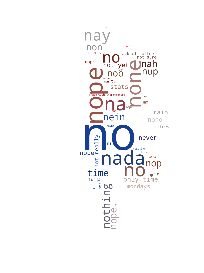

In [48]:
def make_wordcloud_blocked(messages):
    msgs_blocked = messages[(messages["current_user"]==messages["username"])&(messages["answer_type"]=="blocked")]
    text = msgs_blocked["text"].map(lambda t: t.lower())

    from collections import Counter
    counts = Counter(text)

    from PIL import Image
    import numpy as np
    f8_mask = np.array(Image.open("./mario.png"))

    wordcloud = WordCloud(width=1200,
                          height=1200,
                          max_font_size=300,
                         background_color="white",
                         mask=f8_mask).generate_from_frequencies([(w, counts[w]) for w in counts if counts[w] > 1])
    image_colors = ImageColorGenerator(f8_mask);


    wordcloud = wordcloud.recolor(color_func=image_colors)
    plt.imshow(wordcloud)
    plt.axis("off")
    # wordcloud.to_file("blocked.png")
    
make_wordcloud_blocked(msgs_blocked)